![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Librerías adicionales
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Análisis exploratorio de datos

In [6]:
nulos = dataTraining.isnull().sum()               # Busqueda de valores nulos
duplicados = dataTraining.duplicated().sum()      # Busqueda de valores repetidos
titulos_unicos = dataTraining['title'].nunique()  # títulos únicos de películas

print(f'Valores nulos:\n{nulos}')
print(f'\nValores duplicados: {duplicados}')
print(f'\nCantidad de títulos únicos: {titulos_unicos}')

Valores nulos:
year      0
title     0
plot      0
genres    0
rating    0
dtype: int64

Valores duplicados: 1

Cantidad de títulos únicos: 7729


In [7]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [8]:
# Listado de películas con títulos duplicados
dataTraining[dataTraining.duplicated(subset=['title'], keep=False)].sort_values('title').head(6)



,year,title,plot,genres,rating
10885,1916,"20,000 Leagues Under the Sea",captain nemo has built a fantastic submarine f...,"['Action', 'Adventure', 'Sci-Fi']",7.1
10745,1954,"20,000 Leagues Under the Sea","in N , a monster is terrorizing the seas , ...","['Adventure', 'Drama', 'Family', 'Fantasy', 'S...",7.2
9182,1957,3:10 to Yuma,when the charming outlaw ben wade is captured ...,"['Drama', 'Thriller', 'Western']",7.6
2583,2007,3:10 to Yuma,rancher dan evans heads into bisbee to clear u...,"['Adventure', 'Crime', 'Drama', 'Western']",7.8
8062,1938,A Christmas Carol,"in the nineteenth century , in london , the ...","['Drama', 'Family', 'Fantasy']",7.5
4731,2009,A Christmas Carol,"on christmas eve , crotchety miser ebenezer s...","['Animation', 'Drama', 'Family', 'Fantasy']",6.8


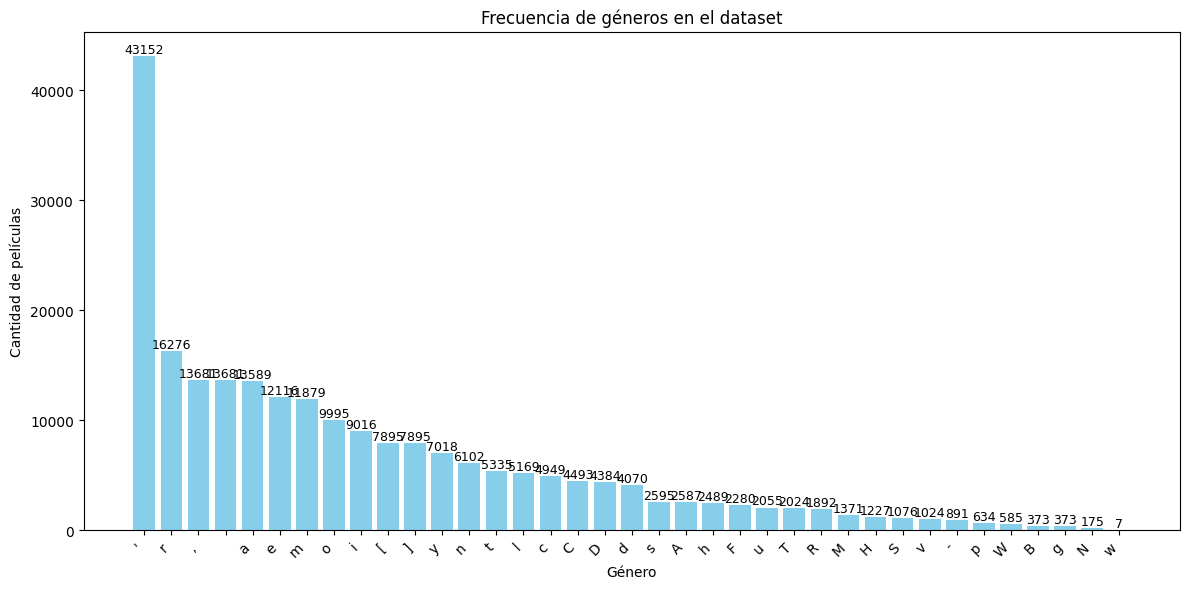

In [9]:
frecuencia_generos = list(chain.from_iterable(dataTraining['genres']))

# Paso 2: Contar la frecuencia de cada género
conteo_generos = Counter(frecuencia_generos)

# Paso 3: Ordenar los géneros por frecuencia
sorted_genres = conteo_generos.most_common()
genres, counts = zip(*sorted_genres)

# Paso 4: Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.title('Frecuencia de géneros en el dataset')
plt.tight_layout()

# Paso 5: Añadir etiquetas a cada barra
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.show()

## Limpieza

In [1]:
# probando actualizaciones en Git

In [11]:
# Lirerías para limpieza de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

dataTraining['plot_clean'] = dataTraining['plot'].apply(remove_stopwords)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\didan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\didan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\didan/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\didan\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(dataTraining['genres'])

genre_labels = mlb.classes_

# Crear nuevo DataFrame con columnas binarias
import pandas as pd
genre_df = pd.DataFrame(genre_matrix, columns=genre_labels)

# Unir al dataframe original si lo deseas
dataTraining_bin = pd.concat([dataTraining.reset_index(drop=True), genre_df], axis=1)
dataTraining_bin.head()


,year,title,plot,genres,rating,Action,Adventure,Animation,Biography,Comedy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","[Drama, Film-Noir, Thriller]",7.2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",[Drama],7.4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","[Action, Crime, Thriller]",6.6,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Multiclasificacion 

## Tokenizacion

## Eliminacion de Stop Word

## Lematizacion

## Entrenamiento del modelo

In [ ]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [ ]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [ ]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [ ]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

np.float64(0.7717668029296991)

## Aplicación del modelo a datos de test

In [ ]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.115316,0.112545,0.021632,0.030826,0.396257,0.116158,0.062036,0.495677,0.066617,0.104482,...,0.025148,0.097838,0.000010,0.392608,0.064968,0.011944,0.018122,0.203969,0.022146,0.019669
4,0.133081,0.087854,0.023964,0.070760,0.343026,0.202546,0.099520,0.511076,0.063784,0.062972,...,0.024627,0.061687,0.002156,0.147331,0.059040,0.012346,0.019008,0.199905,0.040175,0.020344
5,0.158209,0.140732,0.018376,0.067342,0.340637,0.469086,0.006762,0.604303,0.088218,0.103984,...,0.022971,0.334849,0.000000,0.387805,0.112995,0.015059,0.022805,0.392327,0.067718,0.018431
6,0.165241,0.139772,0.027845,0.093197,0.333114,0.146278,0.020983,0.591203,0.076191,0.068679,...,0.111233,0.117495,0.010000,0.186832,0.099408,0.001430,0.038273,0.290187,0.079881,0.018423
7,0.165107,0.177139,0.046025,0.031550,0.317075,0.213078,0.028251,0.463566,0.077800,0.139171,...,0.024349,0.076296,0.000000,0.184966,0.266775,0.004899,0.020132,0.229698,0.023483,0.016585
